<h3>Automatic Detection of Vessel Signatures in Audio Recordings with Spectral Amplitude Variation Signature</h3><br>
<b>Author:</b> Clausius Duque G. Reis (clausiusreis@gmail.com)<br><br>
Comparison of the DEMON algorithm and the novel FAV Signature (Frequency Amplitude Variation) for the automatic underwater detection of boats.

In [3]:
### Libraries ###
%matplotlib inline
from scipy import signal
from scipy.signal import butter, lfilter, decimate, hilbert
from numpy import square, sqrt, mean, abs
from math import floor
from numpy import NaN, Inf, arange, isscalar, asarray, array

import soundfile as sf
import numpy as np
import scipy
import librosa
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import time
import sys

In [4]:
### Necessary functions ###
def smooth(x,window_len=11,window='hanning'):
    win=eval('signal.'+window+'(window_len)')
    filtered = signal.convolve(x, win, mode='same') / sum(win)
       
    filtered[0:int(np.round(window_len/2))] = filtered[int(np.round(window_len/2+1))]
    filtered[int(np.round(-window_len/2+1)):] = filtered[int(np.round(-window_len/2))]
    
    return filtered

def calculate_spectrum(recording, sample_rate):
    fft = np.fft.fft(recording, norm=None)    
    return abs(fft[:int(np.round(sample_rate/2))])

In [5]:
### Frequency Amplitude Variance Signature (FAV) ###
def FAVS (specMatrixDB, rate, maximumFrequency, SDThreshold):

    windowFFT = rate
    if windowFFT%2!=0:
        windowFFT += 1
    
    # Get the mean of the sample frequencies
    specMatrixMean = np.mean(specMatrixDB, axis=1)
    
    # Perform a smooth on the mean with a convolution
    specMatrixMeanS = smooth(specMatrixMean, window='blackman', window_len=8)
    
    # Calculate the Standard Deviation of the smoothed mean
    specMatrixMeanSD = np.std(specMatrixMeanS)
       
    # Find the index of the 1000Hz frequency on the freqs vector
    freqs = librosa.core.fft_frequencies(sr=rate, n_fft=(windowFFT)+1)    
    maxFreq=0
    while (freqs[maxFreq] < maximumFrequency):
        maxFreq += 1

    # Filter the maximum frequency to 1000Hz
    specMatrixMean = specMatrixMean[0:maxFreq]
    specMatrixMeanS = specMatrixMeanS[0:maxFreq]
    
    # Perform the extraction of boat presence and signature
    boatDet   = np.zeros(len(specMatrixMean))
    variance  = np.zeros(len(specMatrixMean))
    for i in arange(5,len(specMatrixMean)-5, 1):
        
        # Calculate the variance between frequencies
        vAmp = specMatrixMeanS[i] - specMatrixMeanS[i+1]
        if vAmp > 0:
            vAmp = 0
        
        # Calculate the cube of the variation
        variance[i] = abs(vAmp*vAmp*vAmp)
        
        # Detect the presence of boats using the provided Standard Deviation Threshold
        if (variance[i] >= specMatrixMeanSD * SDThreshold):
            # Detection window of 5 Hz to help the visualization
            for j in arange(-2,3,1):
                boatDet[i+j] = 1

    # Ignore the detections bellow 20Hz and above the last 10Hz
    i=0
    while (freqs[i] < 20):
        i += 1
    boatDet[:i-1] = 0
    boatDet[-10:] = 0
    
    # Standard deviation array to help plot the results (Not necessary to calculations)
    sdPlot = [specMatrixMeanSD * SDThreshold for sx in specMatrixMean]    
    
    return variance, boatDet, sdPlot

In [32]:
### Load audio ###

# Available samples (0 - 6)
currentPath = "./samples"
currentFiles = ["2015.02.04_05.39.52.wav", "2015.02.04_10.10.42.wav", "2015.02.04_10.40.46.wav",
                "2015.02.04_21.12.44.wav", "2015.02.11_06.27.57.wav", "2015.02.11_15.29.54.wav",
                "2015.04.02_04.48.55.wav"]

# Settings
currentFile = currentFiles[0]
audioChannel = 0
maxFreq = 1000
SDThreshold = 1.5
linewidth = 1
currentMinute = -1

# Load an audio file with separated samplerate, left and right channels
frames, rate = sf.read("/".join([currentPath,currentFile]))

# Load only one channel
if (len(np.shape(frames)) == 1):
    selChannel = frames
else:
    if (audioChannel == 0):
        selChannel = frames[:,0]
    else:
        selChannel = frames[:,1]

sample = selChannel

In [30]:
### Sample of one minute ###
# If you want to sample a specific minute of the recording, set the current minute 
#    and run this code, otherwise the full file will be used as sample

currentMinute = 4
sample = selChannel[(rate*60*currentMinute):(rate*60*(currentMinute+1))]

In [9]:
### Calculate the spectrogram (dB) ###
specMatrix = librosa.stft(sample, n_fft=rate)
specMatrixDB = librosa.amplitude_to_db(specMatrix, ref=np.max, top_db=60)

/tmp/ipykernel_12299/473907256.py:3: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  specMatrixDB = librosa.amplitude_to_db(specMatrix, ref=np.max, top_db=60)


In [10]:
### Calculate the FAV Signature ###
time0 = time.time()
favs, boatdet, sdPlot = FAVS(specMatrixDB, rate, maxFreq, SDThreshold)
time1 = time.time()
timeFAV = time1-time0
print("Time to calulate FAV signature: %s" % (timeFAV))

Time to calulate FAV signature: 0.004349946975708008


Text(0, 0.5, 'Amplitude (dB)')

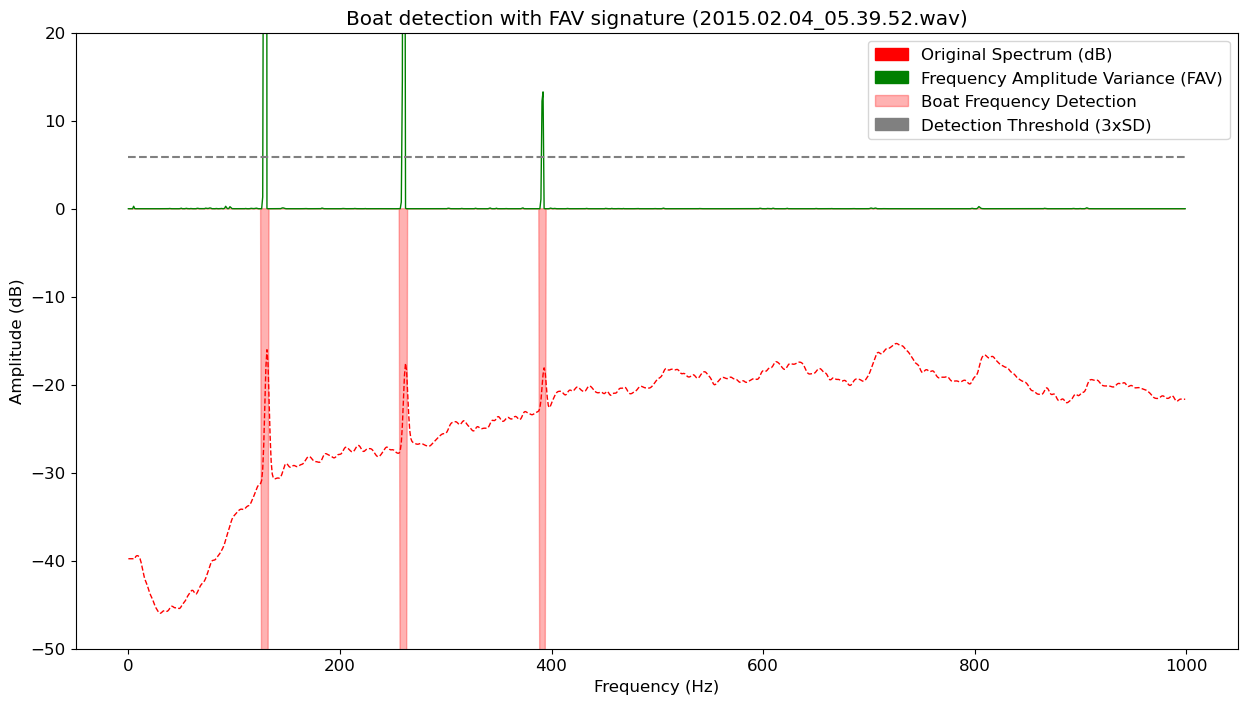

In [40]:
## Plot the results ###
freqs = librosa.core.fft_frequencies(sr=rate, n_fft=(rate)+1)
boatDetVis = copy.copy(boatdet)
boatDetVis[boatDetVis > 0] = np.min(specMatrixDB)

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
leg3 = mpatches.Patch(color='red', label="Original Spectrum (dB)")
leg5 = mpatches.Patch(color='green', label="Frequency Amplitude Variance (FAV)")
leg6 = mpatches.Patch(color='red', alpha=0.3, label="Boat Frequency Detection")
leg8 = mpatches.Patch(color='gray', alpha=1, label="Detection Threshold (3xSD)")
plt.legend(handles=[leg3, leg5, leg6, leg8], loc=1)

# Original Spectrum (DB)
plt.plot(smooth(np.mean(specMatrixDB[:1000], axis=1), window_len=11, window='blackman'), linestyle='--', linewidth=linewidth, color='red')

# FAV Signature
plt.plot(favs[:1000], linewidth=linewidth, color='green')

# Detection threshold
plt.plot(freqs[:maxFreq], sdPlot[:maxFreq], alpha=1, linestyle='--', color='gray')

# Boat detection by FAV
plt.fill(freqs[0:maxFreq], boatDetVis[:maxFreq], linewidth=linewidth, color='red', alpha=0.3)  

plt.xscale('linear')
plt.title('Boat detection with FAV signature (%s)' % (currentFile))
plt.xlabel('Frequency (Hz)')
ax.set_ylim([-50,20]) # Set manually for better visualization
plt.ylabel('Amplitude (dB)')

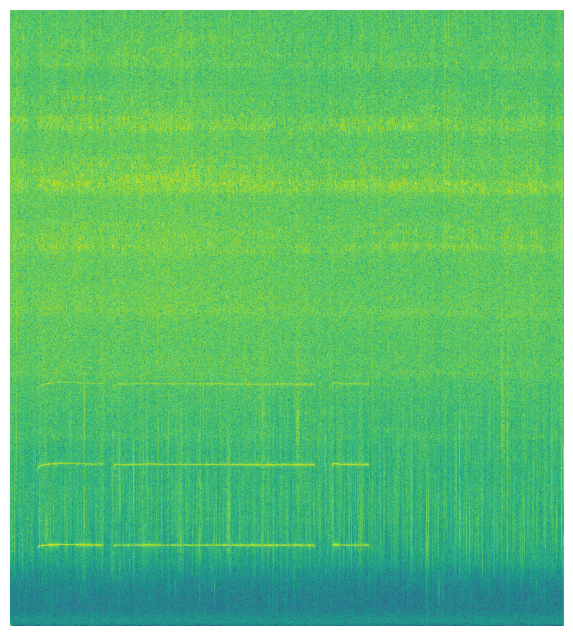

In [71]:
### Plot a spectrogram of the sample ###
maximumFrequency = 1000

specRate = int(np.round(rate))
sampleWindows = int(np.round(len(selChannel)/specRate))
specMatrixa = np.zeros([int(np.round(specRate/2)), sampleWindows])
for i in range(sampleWindows):
    t1 = int(np.round(i*specRate))
    t2 = int(np.round((i+1)*specRate))
    specMatrixa[:,i] = calculate_spectrum(selChannel[t1:t2], specRate)
        
freqs1 = librosa.core.fft_frequencies(sr=rate, n_fft=(specRate)+1)
maxFreq1=0
while (freqs1[maxFreq1] < maximumFrequency):
    maxFreq1 += 1
    
# Create an audio spectrogram of the ENTIRE file
speccmap = plt.cm.viridis
specMatrixDBa = librosa.amplitude_to_db(specMatrixa[:maxFreq1], ref=1.0)
specMatrixDB1a = np.flipud(specMatrixDBa)
norm = plt.Normalize(vmin=specMatrixDB1a.min(), vmax=specMatrixDB1a.max())    
image = speccmap(norm(specMatrixDB1a))
# newImage = scipy.misc.imresize(image, (1000, 2000))
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
plt.axis('off')
# plt.imshow(newImage)
plt.imshow(image)